In [1]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt

filepaths = os.listdir("data/creditcard/")
for fp in filepaths:
    with open("data/creditcard/" + fp, 'rb') as f:
        globals()[fp.replace(".pickle", "")] = pickle.load(f)

Zbiór ten zawiera 29 predyktorów (28 zakodowanych zmiennych bankowych przy pomocy PCA + znormalizowaną wielkość tranzakcji). Jest on ekstremalnie niezbalansowany.

In [2]:
print(creditcard_train_Y.sum() / len(creditcard_train_Y) * 100)
print(creditcard_test_Y.sum() / len(creditcard_test_Y) * 100)

0.17424126050604577
0.1667778519012675


Tak jak poprzednio zacznijmy od modelu referencyjnego - regresji logistycznej:

In [3]:
import statsmodels.api as sm

logit_model = sm.Logit(creditcard_train_Y, creditcard_train_X).fit()
logit_model.summary2()

Optimization terminated successfully.
         Current function value: 0.003871
         Iterations 14


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
================================================================
Model:              Logit            Pseudo R-squared: 0.698    
Dependent Variable: y                AIC:              1822.1019
Date:               2023-03-09 17:05 BIC:              2121.8581
No. Observations:   227845           Log-Likelihood:   -882.05  
Df Model:           28               LL-Null:          -2918.6  
Df Residuals:       227816           LLR p-value:      0.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     14.0000                                     
------------------------------------------------------------------
          Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
------------------------------------------------------------------
x1        0.0843     0.0443    1.9049   0.0568   -0.0024    0.1711
x2        0.0033     0.0602    0.0552   0.9560   -0.1146    0.1213
x3        0.0748     0.0503    1.4888   0.1365   -0.0237    0.1733
x4        0.7432     0.0869    8.5474   0.0000    0.5727    0.9136
x5        0.0748     0.0718    1.0425   0.2972   -0.0658    0.2155
x6       -0.0964     0.0850   -1.1350   0.2564   -0.2629    0.0701
x7       -0.0912     0.0625   -1.4589   0.1446   -0.2138    0.0313
x8       -0.1664     0.0319   -5.2123   0.0000   -0.2289   -0.1038
x9       -0.2541     0.1325   -1.9179   0.0551   -0.5137    0.0056
x10      -0.8602     0.1159   -7.4186   0.0000   -1.0874   -0.6329
x11       0.0958     0.0862    1.1120   0.2661   -0.0731    0.2647
x12       0.0787     0.0946    0.8321   0.4054   -0.1067    0.2641
x13      -0.3608     0.0937   -3.8521   0.0001   -0.5443   -0.1772
x14      -0.5478     0.0690   -7.9344   0.0000   -0.6831   -0.4125
x15      -0.0696     0.0948   -0.7338   0.4630   -0.2554    0.1162
x16      -0.0480     0.1589   -0.3018   0.7628   -0.3594    0.2635
x17       0.0013     0.0763    0.0164   0.9869   -0.1483    0.1508
x18      -0.1972     0.1569   -1.2569   0.2088   -0.5047    0.1103
x19       0.1507     0.1122    1.3429   0.1793   -0.0693    0.3707
x20      -0.3775     0.0760   -4.9688   0.0000   -0.5264   -0.2286
x21       0.3734     0.0659    5.6705   0.0000    0.2444    0.5025
x22       0.4916     0.1454    3.3808   0.0007    0.2066    0.7765
x23      -0.0474     0.0670   -0.7085   0.4786   -0.1787    0.0838
x24       0.2110     0.1696    1.2437   0.2136   -0.1215    0.5434
x25      -0.1179     0.1474   -0.8000   0.4237   -0.4067    0.1709
x26       0.0558     0.2061    0.2708   0.7866   -0.3482    0.4598
x27      -0.8037     0.1367   -5.8794   0.0000   -1.0716   -0.5358
x28      -0.2721     0.1007   -2.7020   0.0069   -0.4695   -0.0747
x29       8.7369     0.1713   51.0016   0.0000    8.4012    9.0727
================================================================

"""

Jak widać otrzymaliśmy duzą ilość niesistotnych mziennych. Naszym kolejnym krokiem powinno być odrzucenie nieistotnych zmiennych (pojedynczo!), sprawdzenie współliniowości miedzy zmiennymi, do czasu aż dojdziemy do modelu, który jest poprawnie skonstruowany i widać w nim objawów overfittingu. 

Zamiast robić to wszystko ręcznie i krok po kroku, spróbujmy czegoś innego.

# Regularyzacja LASSO, Ridge i Elastic Net w H2O

In [4]:
import h2o
import pandas as pd
h2o.init(ip = "localhost",
        port = 54321,
        nthreads = -1,
        min_mem_size = "20g")

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.18" 2023-01-17; OpenJDK Runtime Environment (build 11.0.18+10-post-Ubuntu-0ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.18+10-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)
  Starting server from /home/maju116/anaconda3/lib/python3.9/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpvnybflt3
  JVM stdout: /tmp/tmpvnybflt3/h2o_maju116_started_from_python.out
  JVM stderr: /tmp/tmpvnybflt3/h2o_maju116_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,06 secs
H2O_cluster_timezone:,Europe/Warsaw
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.1
H2O_cluster_version_age:,1 month
H2O_cluster_name:,H2O_from_python_maju116_nfp3ca
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,20 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [5]:
creditcard_train = pd.DataFrame(np.column_stack((creditcard_train_X, creditcard_train_Y)))
creditcard_train.columns = ["V" + str(i) for i in range(28)] + ["amount", "fraud"]
creditcard_train["fraud"] = ["F" if x == 1 else "NF" for x in creditcard_train["fraud"]]
creditcard_test = pd.DataFrame(np.column_stack((creditcard_test_X, creditcard_test_Y)))
creditcard_test.columns = ["V" + str(i) for i in range(28)] + ["amount", "fraud"]
creditcard_test["fraud"] = ["F" if x == 1 else "NF" for x in creditcard_test["fraud"]]

In [6]:
creditcard_train_h2o = h2o.H2OFrame(creditcard_train, destination_frame="creditcard_train")
creditcard_test_h2o = h2o.H2OFrame(creditcard_test, destination_frame="creditcard_test")
h2o.ls()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


,key
0,creditcard_test
1,creditcard_train


In [7]:
creditcard_train_h2o["fraud"] = creditcard_train_h2o["fraud"].asfactor()
creditcard_test_h2o["fraud"] = creditcard_test_h2o["fraud"].asfactor()

Następnie zbudujemy 3 modele:

In [8]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

# LASSO
card_lasso_balanced = H2OGeneralizedLinearEstimator(alpha=1,
                                                    family="binomial",
                                                    lambda_search=True,
                                                    nfolds=5,
                                                    balance_classes=True,
                                                    class_sampling_factors=[0.5, 0.5],
                                                    seed=1234,
                                                    score_each_iteration=True,
                                                    model_id="card_lasso_balanced")

card_lasso_balanced.train(x=list(range(0, 29)),
                          y="fraud",
                          training_frame=h2o.get_frame("creditcard_train"),
                          validation_frame=h2o.get_frame("creditcard_test"))

# Ridge
card_ridge_balanced = H2OGeneralizedLinearEstimator(alpha=0,
                                                    family="binomial",
                                                    lambda_search=True,
                                                    nfolds=5,
                                                    balance_classes=True,
                                                    class_sampling_factors=[0.5, 0.5],
                                                    seed=1234,
                                                    score_each_iteration=True,
                                                    model_id="card_ridge_balanced")

card_ridge_balanced.train(x=list(range(0, 29)),
                          y="fraud",
                          training_frame=h2o.get_frame("creditcard_train"),
                          validation_frame=h2o.get_frame("creditcard_test"))

# Elastic Net
card_elastic_net_balanced = H2OGeneralizedLinearEstimator(alpha=0.5,
                                                          family="binomial",
                                                          lambda_search=True,
                                                          nfolds=5,
                                                          balance_classes=True,
                                                          class_sampling_factors=[0.5, 0.5],
                                                          seed=1234,
                                                          score_each_iteration=True,
                                                          model_id="card_elastic_net_balanced")

card_elastic_net_balanced.train(x=list(range(0, 29)),
                                y="fraud",
                                training_frame=h2o.get_frame("creditcard_train"),
                                validation_frame=h2o.get_frame("creditcard_test"))

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
glm Model Build progress: |

/home/maju116/anaconda3/lib/python3.9/site-packages/h2o/job.py:83: UserWarning: Reached maximum number of iterations 51!
  warnings.warn(w)


██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: card_elastic_net_balanced


GLM Model: summary
    family    link    regularization                                 lambda_search                                                                      number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  ------  ---------------------------------------------  ---------------------------------------------------------------------------------  ----------------------------  -----------------------------  ----------------------  ----------------
    binomial  logit   Elastic Net (alpha = 0.5, lambda = 3.676E-5 )  nlambda = 100, lambda.max = 0.02717, lambda.min = 3.676E-5, lambda.1se = 0.001149  29                            28                             134                     creditcard_train

ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.000672041586198401
RMSE: 0.025923764892438
LogLoss: 0.003893045849696193
AUC: 0.9787790673464867
AUCPR: 0.9999512138374709
Gini: 0.9575581346929734
Null degrees of freedom: 227844
Residual degrees of freedom: 227816
Null deviance: 5837.180609854768
Residual deviance: 1774.0220632480807
AIC: 1832.0220632480807

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.8915548731947767
       F    NF      Error    Rate
-----  ---  ------  -------  ----------------
F      312  85      0.2141   (85.0/397.0)
NF     76   227372  0.0003   (76.0/227448.0)
Total  388  227457  0.0007   (161.0/227845.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.891555     0.999646  209
max f2                       0.443999     0.999763  308
max f0point5                 0.954535     0.999656  179
max accuracy                 0.891555     0.999293  209
max precision                0.99999      1         0
max recall                   1.14228e-05  1         399
max specificity              0.99999      1         0
max absolute_mcc             0.911704     0.79513   203
max min_per_class_accuracy   0.998904     0.929171  51
max mean_per_class_accuracy  0.998285     0.93992   66
max tns                      0.99999      397       0
max fns                      0.99999      221048    0
max fps                      1.14228e-05  397       399
max tps                      1.14228e-05  227448    399
max tnr                      0.99999      1         0
max fnr                      0.99999      0.971862  0
max fpr                      1.14228e-05  1         399
max tpr                      1.14228e-05  1         399

Gains/Lift Table: Avg response rate: 99.83 %, avg score: 99.83 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100024                   0.999994           1.00175   1.00175            1                0.999998  1                           0.999998            0.0100199       0.0100199                  0.174545  0.174545           0.0100199
2        0.0200004                   0.999985           1.00175   1.00175            1                0.999989  1                           0.999993            0.0100155       0.0200353                  0.174545  0.174545           0.0200353
3        0.0300029                   0.999978           1.00175   1.00175            1                0.999981  1                           0.999989            0.0100199       0.0300552                 

Sprawdźmy teraz jak wyglądają współczynniki naszych modeli:

In [9]:
card_lasso_balanced.coef()

{'Intercept': 8.04435758609876,
 'V0': -0.019440430869833835,
 'V1': 0.0,
 'V2': -0.03687651364324285,
 'V3': -0.6532208421506859,
 'V4': -0.05991244466401129,
 'V5': 0.01829393714382456,
 'V6': 0.0,
 'V7': 0.18085602062317105,
 'V8': 0.14059144931902975,
 'V9': 0.6504738191621546,
 'V10': -0.07608014677552888,
 'V11': 0.0,
 'V12': 0.28926948337872777,
 'V13': 0.5911516888800654,
 'V14': 0.016959929078672307,
 'V15': 0.15053842928802671,
 'V16': 0.0342573656395532,
 'V17': 0.07329998889228367,
 'V18': -0.06178017937493766,
 'V19': 0.15725291583336826,
 'V20': -0.3025282908886735,
 'V21': -0.37382514531943783,
 'V22': 0.044080781807294814,
 'V23': -0.12627929080794936,
 'V24': 0.07913746689664379,
 'V25': 0.0,
 'V26': 0.42324453514590094,
 'V27': 0.11347421111066325,
 'amount': -0.4016482486561534}

In [10]:
card_ridge_balanced.coef()

{'Intercept': 2.4821244563844145,
 'V0': -0.05859814201295951,
 'V1': 0.013810326315504802,
 'V2': -0.052409113385559224,
 'V3': -0.643976468287512,
 'V4': -0.055000285932768095,
 'V5': 0.0773667919985193,
 'V6': 0.07280894619174862,
 'V7': 0.1764050873965583,
 'V8': 0.2622166805608723,
 'V9': 0.6967025716530275,
 'V10': -0.09798897112026399,
 'V11': -0.014772918579390263,
 'V12': 0.3163524628272505,
 'V13': 0.5754934508580929,
 'V14': 0.07966964156100804,
 'V15': 0.1229896739370421,
 'V16': -0.0036724853793041845,
 'V17': 0.1273834610552926,
 'V18': -0.10694533588615347,
 'V19': 0.2929654526933336,
 'V20': -0.3252787649654219,
 'V21': -0.4269770935323493,
 'V22': 0.045703157112671644,
 'V23': -0.17894225689768048,
 'V24': 0.11982243232027644,
 'V25': -0.06327225345778248,
 'V26': 0.6168702916791666,
 'V27': 0.19882303642186108,
 'amount': -6.044859445985339}

In [11]:
card_elastic_net_balanced.coef()

{'Intercept': 7.2961420158131105,
 'V0': -0.021390015235788835,
 'V1': 9.24797441945084e-06,
 'V2': -0.03604280048811046,
 'V3': -0.6422774163818495,
 'V4': -0.059716496573949396,
 'V5': 0.0383468528473867,
 'V6': 0.0011818060553695864,
 'V7': 0.1843089546401298,
 'V8': 0.16727015318979124,
 'V9': 0.6444382267162744,
 'V10': -0.08652320908349848,
 'V11': 0.0,
 'V12': 0.2949846526253442,
 'V13': 0.5876285085960359,
 'V14': 0.03980487445095487,
 'V15': 0.14631564368341127,
 'V16': 0.02770911458035358,
 'V17': 0.09070743590560844,
 'V18': -0.07425204393680514,
 'V19': 0.1707082106840605,
 'V20': -0.304959084022939,
 'V21': -0.3823323859840655,
 'V22': 0.046101167492325214,
 'V23': -0.13669297929657895,
 'V24': 0.09250612023525111,
 'V25': -0.020755253156336268,
 'V26': 0.44124149915134675,
 'V27': 0.12002578301522228,
 'amount': -1.1474027600823313}

Oraz miary dopasowania:

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
0.978239437727736
0.956478875455472
529.6511045759247


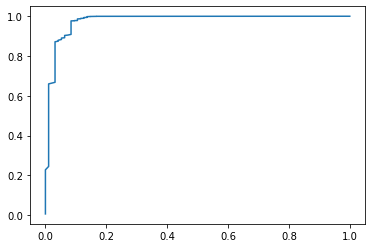

2.666309650388883e-05
glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
0.9794405783393014
0.9588811566786029
545.3994335462991


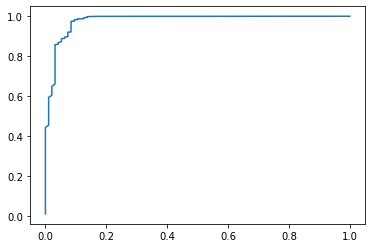

3.812915262423545e-05
glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
0.9783402269191364
0.9566804538382727
535.4970499774645


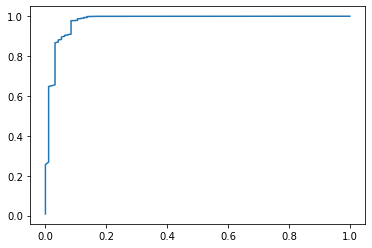

3.675567634042965e-05


In [12]:
pred_lasso_balanced = card_lasso_balanced.predict(creditcard_test_h2o)
perf_lasso_balanced = card_lasso_balanced.model_performance(creditcard_test_h2o)

print(perf_lasso_balanced.auc())
print(perf_lasso_balanced.gini())
print(perf_lasso_balanced.aic())

cm_lasso_balanced = card_lasso_balanced.confusion_matrix(valid = True, metrics='f2')

fpr = perf_lasso_balanced.fprs
tpr = perf_lasso_balanced.tprs
plt.plot(fpr, tpr)
plt.show()

print(card_lasso_balanced._model_json['output']['lambda_best'])

pred_ridge_balanced = card_ridge_balanced.predict(creditcard_test_h2o)
perf_ridge_balanced = card_ridge_balanced.model_performance(creditcard_test_h2o)

print(perf_ridge_balanced.auc())
print(perf_ridge_balanced.gini())
print(perf_ridge_balanced.aic())

cm_ridge_balanced = card_ridge_balanced.confusion_matrix(valid = True, metrics='f2')

fpr = perf_ridge_balanced.fprs
tpr = perf_ridge_balanced.tprs
plt.plot(fpr, tpr)
plt.show()

print(card_ridge_balanced._model_json['output']['lambda_best'])

pred_elastic_net_balanced = card_elastic_net_balanced.predict(creditcard_test_h2o)
perf_elastic_net_balanced = card_elastic_net_balanced.model_performance(creditcard_test_h2o)

print(perf_elastic_net_balanced.auc())
print(perf_elastic_net_balanced.gini())
print(perf_elastic_net_balanced.aic())

cm_elastic_net_balanced = card_elastic_net_balanced.confusion_matrix(valid=True, metrics='f2')

fpr = perf_elastic_net_balanced.fprs
tpr = perf_elastic_net_balanced.tprs
plt.plot(fpr, tpr)
plt.show()

print(card_elastic_net_balanced._model_json['output']['lambda_best'])

Na zakończenie zapiszmy modele:

In [ ]:
card_lasso_balanced.save_mojo(os.getcwd())
card_ridge_balanced.save_mojo(os.getcwd())
card_elastic_net_balanced.save_mojo(os.getcwd())

I zamkniemy cluster:

In [ ]:
h2o.shutdown()